In [1]:
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
import pprint

#### Find BBox and Mask

In [2]:
train_folder_path = "C:/Users/richa_0/Downloads/coral_masks.v4i.coco/train/"
output_directory = "C:/Users/richa_0/Downloads/coral_masks.v4i.coco/Masks/"

# Initialize a dictionary to store bounding box coordinates
bbox_coords = {}
ground_truth_masks = {}

# Iterate through each file in the directory
for file_name in os.listdir(train_folder_path):
    if file_name.endswith('.json'):
        # Construct the full path to the JSON file
        json_file_path = os.path.join(train_folder_path, file_name)
        
        # Load the JSON file
        with open(json_file_path, 'r') as f:
            coco_data = json.load(f)
        
        # Extract the annotations from the COCO data
        annotations = coco_data['annotations']
        
        # Process each annotation to extract the bounding box
        for annotation in annotations:
            image_id = annotation['image_id']
            bbox = annotation['bbox']
            category_id = annotation['category_id']
            segmentation = annotation['segmentation']

            image_info = coco_data['images'][0]
            image_height = image_info['height']
            image_width = image_info['width']
            
            # Convert bbox to a more readable format [x_min, y_min, x_max, y_max]
            x_min, y_min, width, height = bbox
            x_max = x_min + width
            y_max = y_min + height
            bbox_array = np.array([x_min, y_min, x_max, y_max])
            
            # Store the bounding box coordinates in the dictionary
            bbox_coords[image_id] = (bbox_array)

            binary_mask = np.zeros((image_height, image_width), dtype=np.uint8)
            for segment in segmentation:
                polygon = np.array(segment).reshape((-1, 2))
                cv2.fillPoly(binary_mask, [polygon.astype(np.int32)], 1)

            # Store the mask in the dictionary
            ground_truth_masks[image_id] = binary_mask == 1

            # Create the output directory if it doesn't exist
            os.makedirs(output_directory, exist_ok=True)

            # Save the binary mask with a unique file name
            #output_path = os.path.join(output_directory, f'binary_mask_{image_id}.png')
            #cv2.imwrite(output_path, binary_mask * 255)

In [3]:
# Print the bounding box coordinates (optional)
pprint.pprint(bbox_coords)
pprint.pprint(ground_truth_masks)

{0: array([ 400,  236, 1528, 1440]),
 1: array([ 564,  204, 1732, 1384]),
 2: array([ 604,  348, 1392, 1156]),
 3: array([ 796,  584, 1120,  912]),
 4: array([ 656,  604, 1056,  996]),
 5: array([ 868,  392, 1352,  916]),
 6: array([ 448,  264, 1248, 1100]),
 7: array([ 704,  464, 1160,  896]),
 8: array([1084,  572, 1336,  816]),
 9: array([ 880,  612, 1264,  976]),
 10: array([ 692,  448, 1176,  996]),
 11: array([ 352,  112, 1464, 1316]),
 12: array([ 436,  224, 1476, 1216]),
 13: array([ 288,  152, 1616, 1340]),
 14: array([1052,  560, 1284,  788]),
 15: array([ 640,  220, 1700, 1324]),
 16: array([612, 484, 964, 812]),
 17: array([ 844,  532, 1144,  832]),
 18: array([ 628,  308, 1364, 1032]),
 19: array([ 648,  524, 1256, 1140]),
 20: array([ 504,  524, 1184, 1180]),
 21: array([ 840,  444, 1716, 1308]),
 22: array([ 628,  384, 1232, 1004]),
 23: array([ 416,  144, 1636, 1372]),
 24: array([ 668,  428, 1356, 1080]),
 25: array([ 848,  448, 1656, 1256]),
 26: array([1096,  856, 14

#### Methods

In [4]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

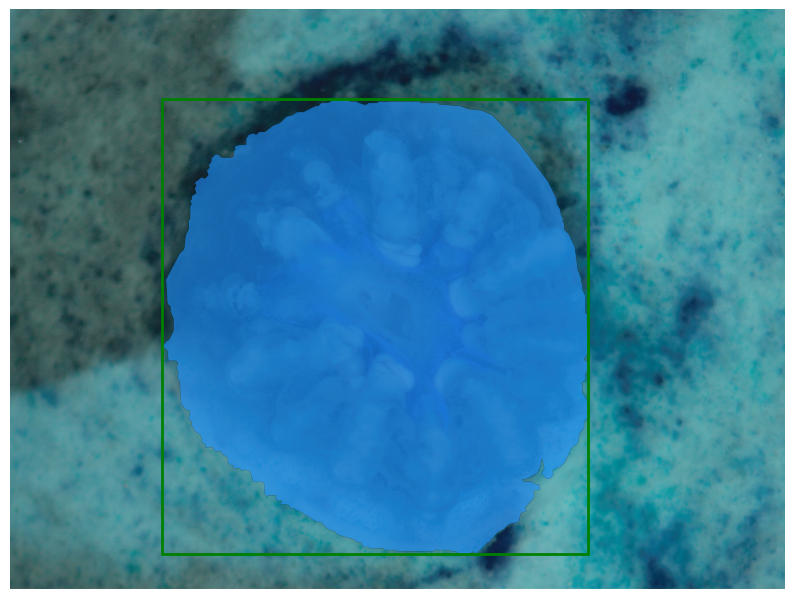

In [5]:
image = cv2.imread("C:/Users/richa_0/Downloads/coral_masks.v4i.coco/train/94_1_01_20230414_png.rf.da94f0e12f90deb26026e1dde4d7f464.jpg") #Gets the actual image itself with nothing on it

plt.figure(figsize=(10,10))
plt.imshow(image)
show_box(bbox_coords[0], plt.gca())
show_mask(ground_truth_masks[0], plt.gca())
plt.axis('off')
plt.show()

#### Prepare Fine-Tuning

In [6]:
import torch
print(torch.__version__)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

2.2.0+cu118
cuda:0


In [7]:
MODEL_TYPE = "vit_h"
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
sam = sam_model_registry[MODEL_TYPE](checkpoint=r"C:\Users\richa_0\Documents\Coral Research\Machine Learning Models\sam_vit_h_4b8939.pth").to(device=device)

In [8]:
# This step increases memory usage by a lot when preparing image as tensor

from collections import defaultdict
from segment_anything.utils.transforms import ResizeLongestSide

import torch

transformed_data = defaultdict(dict)
image_index = 0

for file_name in os.listdir(train_folder_path):
    if (file_name.endswith('.jpg') and image_index < 50):
        image_file_path = os.path.join(train_folder_path, file_name)
        
        image = cv2.imread(image_file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        transform = ResizeLongestSide(sam.image_encoder.img_size)
        input_image = transform.apply_image(image)
        input_image_torch = torch.as_tensor(input_image, device=device)
        transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]
        
        input_image = sam.preprocess(transformed_image)
        original_image_size = image.shape[:2]
        input_size = transformed_image.shape[-2:]

        transformed_data[image_index]['image'] = input_image
        transformed_data[image_index]['input_size'] = input_size
        transformed_data[image_index]['original_image_size'] = original_image_size

        image_index += 1

In [9]:
# Set up the optimizer, hyperparameter tuning will improve performance here
lr = 2e-5
wd = 0
optimizer = torch.optim.Adam(sam.mask_decoder.parameters(), lr=lr, weight_decay=wd)

loss_fn = torch.nn.MSELoss()
# loss_fn = torch.nn.BCELoss()

In [10]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   3114 MiB |   3123 MiB |   4231 MiB |   1117 MiB |\n|       from large pool |   3103 MiB |   3112 MiB |   4221 MiB |   1117 MiB |\n|       from small pool |     10 MiB |     10 MiB |     10 MiB |      0 MiB |\n|---------------------------------------------------------------------------|\n| Active memory         |   3114 MiB |   3123 MiB |   4231 MiB |   1117 MiB |\n|       from large pool |   3103 MiB |   3112 MiB |

#### Fine-Tuning (unfinished)

In [11]:
from statistics import mean

from tqdm import tqdm
from torch.nn.functional import threshold, normalize

num_epochs = 25
losses = []

for epoch in range(num_epochs):
    epoch_losses = []
    for k in range(50):
        input_image = transformed_data[k]['image'].to(device = device) #These lines are for the transformed image
        input_size = transformed_data[k]['input_size']
        original_image_size = transformed_data[k]['original_image_size']
    
        # No grad here as we don't want to optimise the encoders
        with torch.no_grad():
            image_embedding = sam.image_encoder(input_image)
            
            prompt_box = bbox_coords[k] #Gets the images bbox
            box = transform.apply_boxes(prompt_box, original_image_size)
            box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
            box_torch = box_torch[None, :]
            
            sparse_embeddings, dense_embeddings = sam.prompt_encoder(
              points=None,
              boxes=box_torch,
              masks=None,
            )
        low_res_masks, iou_predictions = sam.mask_decoder(
          image_embeddings=image_embedding,
          image_pe=sam.prompt_encoder.get_dense_pe(),
          sparse_prompt_embeddings=sparse_embeddings,
          dense_prompt_embeddings=dense_embeddings,
          multimask_output=False,
        )
        
        upscaled_masks = sam.postprocess_masks(low_res_masks, input_size, original_image_size).to(device = device)
        binary_mask = normalize(threshold(upscaled_masks, 0.0, 0))
        
        gt_mask_resized = torch.from_numpy(np.resize(ground_truth_masks[k], (1, 1, ground_truth_masks[k].shape[0], ground_truth_masks[k].shape[1]))).to(device = device) #The ground truth masks are used here
        gt_binary_mask = torch.as_tensor(gt_mask_resized > 0, dtype=torch.float32)
        
        loss = loss_fn(binary_mask, gt_binary_mask)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    losses.append(epoch_losses)
    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

#torch.save(sam.state_dict(), os.path.join(save_dir, f'sam_model_epoch_{epoch}.pth'))

EPOCH: 0
Mean loss: 0.07117150696925818
EPOCH: 1
Mean loss: 0.0711362557252869
EPOCH: 2
Mean loss: 0.07094116510823369
EPOCH: 3
Mean loss: 0.06987433488480747
EPOCH: 4
Mean loss: 0.06864796560257673
EPOCH: 5
Mean loss: 0.07030591638525947
EPOCH: 6
Mean loss: 0.0714293965161778
EPOCH: 7
Mean loss: 0.07354936041170732
EPOCH: 8
Mean loss: 0.0752507267985493
EPOCH: 9
Mean loss: 0.07261326861102134
EPOCH: 10
Mean loss: 0.0706809619977139
EPOCH: 11
Mean loss: 0.07146290669683367
EPOCH: 12
Mean loss: 0.0715452135936357
EPOCH: 13
Mean loss: 0.07197888547787443
EPOCH: 14
Mean loss: 0.07269863454857842
EPOCH: 15
Mean loss: 0.07316822005435825
EPOCH: 16
Mean loss: 0.0731974468077533
EPOCH: 17
Mean loss: 0.07100502494955435
EPOCH: 18
Mean loss: 0.08148369448026642
EPOCH: 19
Mean loss: 0.08760502009885386
EPOCH: 20
Mean loss: 0.08738904793281108
EPOCH: 21
Mean loss: 0.08832707720110193
EPOCH: 22
Mean loss: 0.0873356237797998
EPOCH: 23
Mean loss: 0.08724351269891485
EPOCH: 24
Mean loss: 0.0849246552

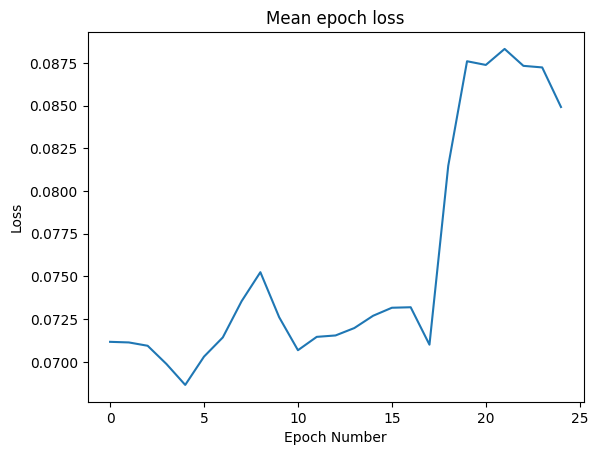

In [12]:
mean_losses = [mean(x) for x in losses]
mean_losses

plt.plot(list(range(len(mean_losses))), mean_losses)
plt.title('Mean epoch loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')

plt.show()

In [15]:
# Load up the model with default weights
sam_model_orig = sam_model_registry[MODEL_TYPE](checkpoint=r"C:\Users\richa_0\Documents\Coral Research\Machine Learning Models\sam_vit_h_4b8939.pth").to(device=device)

In [16]:
predictor_tuned = SamPredictor(sam)
predictor_original = SamPredictor(sam_model_orig)

In [17]:
# The model has not seen keys[21] (or keys[20]) since we only trained on keys[:20]
image = cv2.imread("C:/Users/richa_0/Downloads/coral_masks.v4i.coco/train/94_1_01_20230414_png.rf.da94f0e12f90deb26026e1dde4d7f464.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

predictor_tuned.set_image(image)
predictor_original.set_image(image)

input_bbox = np.array(bbox_coords[0])

masks_tuned, _, _ = predictor_tuned.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)

masks_orig, _, _ = predictor_original.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)

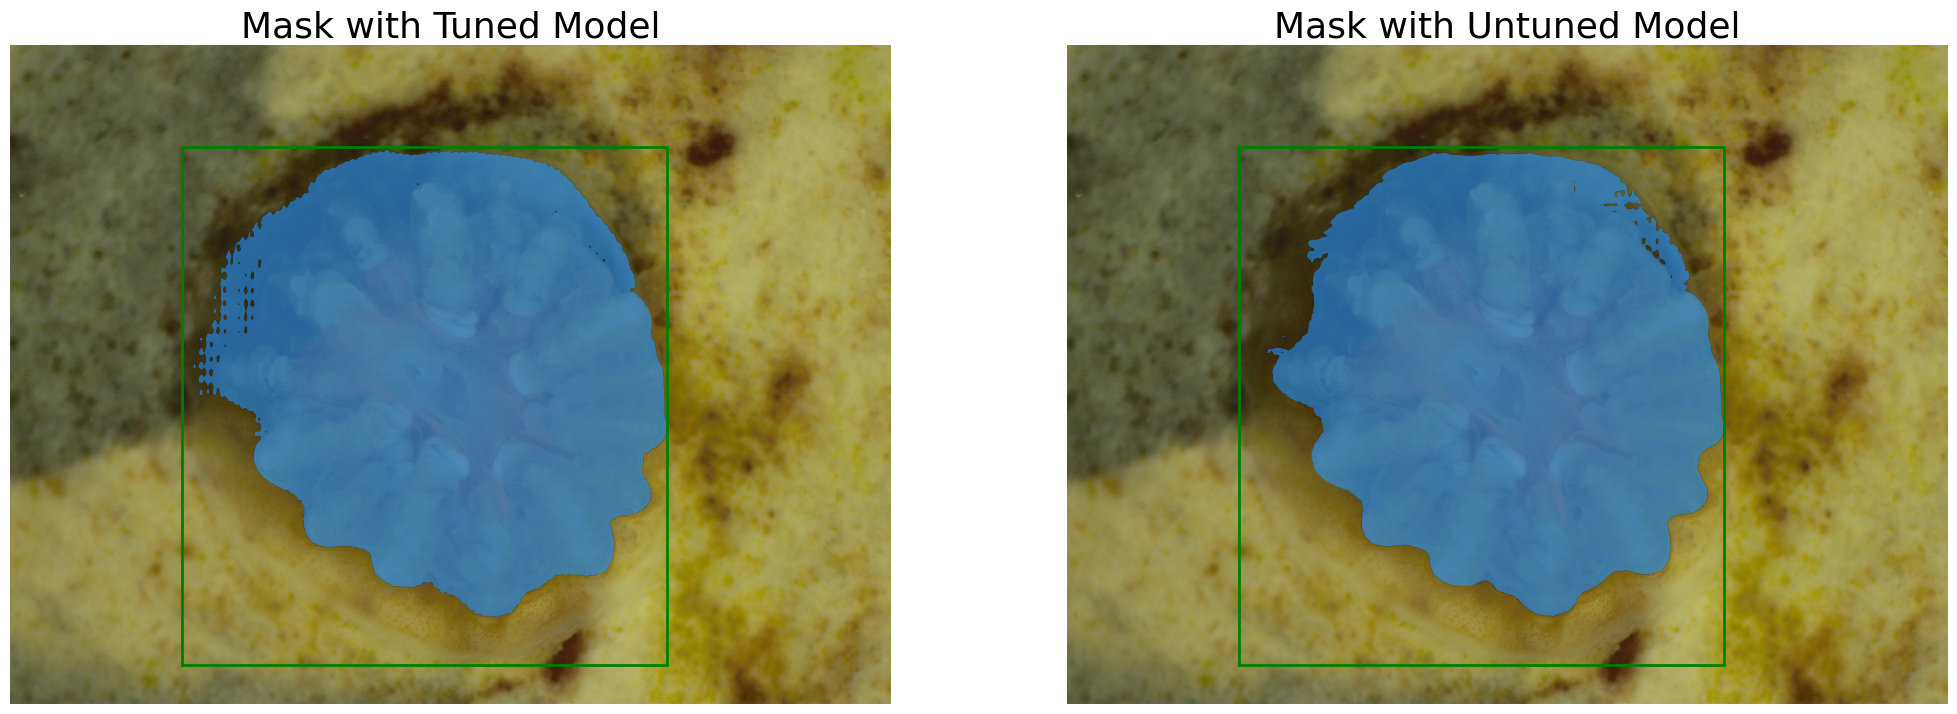

In [18]:
%matplotlib inline 
_, axs = plt.subplots(1, 2, figsize=(25, 25))


axs[0].imshow(image)
show_mask(masks_tuned, axs[0])
show_box(input_bbox, axs[0])
axs[0].set_title('Mask with Tuned Model', fontsize=26)
axs[0].axis('off')


axs[1].imshow(image)
show_mask(masks_orig, axs[1])
show_box(input_bbox, axs[1])
axs[1].set_title('Mask with Untuned Model', fontsize=26)
axs[1].axis('off')

plt.show()  

In [20]:
save_dir = "C:/Users/richa_0/Downloads/"

torch.save(sam.state_dict(), os.path.join(save_dir, f'sam_model_epoch_{epoch}.pth'))

In [ ]:
!pip install roboflow

from roboflow import Roboflow
import os

rf = Roboflow(api_key="W8Wh3vwPre13GJ9ArQue")
project = rf.workspace("brad-dwyer").project("car-parts-pgo19")
version = project.version(6)
dataset = version.download("sam2")

# rename dataset.location to "data"
os.rename(dataset.location, "/content/data")

In [ ]:
!git clone https://github.com/facebookresearch/sam2.git

In [ ]:
!wget -O /content/sam2/sam2/configs/train.yaml 'https://drive.usercontent.google.com/download?id=11cmbxPPsYqFyWq87tmLgBAQ6OZgEhPG3'

In [ ]:
%cd ./sam2/

In [ ]:
!pip install -e .[dev] -q

In [ ]:
!cd ./checkpoints && ./download_ckpts.sh

In [ ]:
import os
import re

FOLDER = "/content/data/train"

for filename in os.listdir(FOLDER):
    # Replace all except last dot with underscore
    new_filename = filename.replace(".", "_", filename.count(".") - 1)
    if not re.search(r"_\d+\.\w+$", new_filename):
        # Add an int to the end of base name
        new_filename = new_filename.replace(".", "_1.")
    os.rename(os.path.join(FOLDER, filename), os.path.join(FOLDER, new_filename))